### How to use this notebook
#### Imports
TODO: Write which packages the user has to import to use this notebook. Something like:
> pip install pandas matplotlib numpy seaborn basemap etc..

#### Data
In order to run this notebook you must first extract __birds.csv__ from __birds.zip__

In [44]:
# TODO: Cleanup imports that are not needed
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import itertools
import collections
import json
import nltk
from nltk.corpus import stopwords
from dwca.read import DwCAReader
from mpl_toolkits.basemap import Basemap
from IPython.display import display
import re
pd.set_option("display.max_columns", None)
import datetime
import warnings
warnings.filterwarnings("ignore")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

#### Importing data
We start by reading the file to a dataframe:

In [45]:
birds = pd.read_csv("birds.csv", index_col=False)
display(birds.head())
print("Number of rows:", birds.shape[0])

,vernacularName,verbatimScientificName,order,family,genus,specificEpithet,eventDate,year,month,day,stateProvince,locality,decimalLatitude,decimalLongitude,individualCount,iucnRedListCategory
0,Lesser Black-backed Gull,Larus fuscus,Charadriiformes,Laridae,Larus,fuscus,2016-05-31T00:00:00,2016,5,31,Suðurland,Heimaey--Víkin,63.408356,-20.280504,1.0,LC
1,Ruddy Turnstone,Arenaria interpres,Charadriiformes,Scolopacidae,Arenaria,interpres,2004-09-17T00:00:00,2004,9,17,Suðurnes,Garður,64.072426,-22.660074,NaN,LC
2,Glaucous Gull,Larus hyperboreus,Charadriiformes,Laridae,Larus,hyperboreus,2010-11-24T00:00:00,2010,11,24,Norðurland eystra,Húsavík--hafnarsvæði (harbour area),66.044800,-17.349987,NaN,LC
3,Eurasian Wigeon,Mareca penelope,Anseriformes,Anatidae,Anas,penelope,2018-06-24T00:00:00,2018,6,24,Suðurland,"(63.6731,-20.3561)",63.673130,-20.356092,2.0,LC
4,Mallard,Anas platyrhynchos,Anseriformes,Anatidae,Anas,platyrhynchos,2020-02-29T00:00:00,2020,2,29,Vestfirðir,Bolungarvik--hafnarsvaedi (harbour area),66.157510,-23.244152,11.0,LC


Number of rows: 751153


Most of these columns are self-explanatory but there are a couple of things we want to clear up.

**verbatimScientificName** is the [binomial name](https://en.wikipedia.org/wiki/Binomial_nomenclature) of the species. This is also the same as the columns **genus** + **specificEpithet**. 

Regarding the [taxonomic rank](https://en.wikipedia.org/wiki/Taxonomic_rank), we only include **order**, **family**, **genus** and **specificEpithet** and exclude **kingdom**, **phylum** and **class**, since these fields would be identical for all records (*Animalia*, *Chordata* and *Aves*)

The column **individualCount** says how many birds of the given species were spotted at the given time and location.

**iucnRedListCategory** is the [conservation status](https://www.iucnredlist.org/) of the species.

<img src="images/Status_iucn3.1.svg.png" alt="IUCN Red List" title="Conservation status" />

#### Cleaning data
There are a couple of duplicated rows which we can remove:

TODO: Perhaps show some duplicated rows

In [46]:
birds = birds.drop_duplicates()
print("Number of rows:", birds.shape[0])

Number of rows: 655657


As we saw [above](#importing-data), there are some columns where **individualCount** is NaN. We think it's safe to replace these values with 1.

TODO: Rationalize why we think we can replace theses values. Similar case here: https://github.com/nmtarr/wildlife-wrangler/blob/master/wrangler_functions.py#L443

In [47]:
print("Before")
display(birds[["vernacularName","individualCount"]].head())
birds["individualCount"] = birds["individualCount"].fillna(value=1)
print("After")
display(birds[["vernacularName","individualCount"]].head())

Before


,vernacularName,individualCount
0,Lesser Black-backed Gull,1.0
1,Ruddy Turnstone,NaN
2,Glaucous Gull,NaN
3,Eurasian Wigeon,2.0
4,Mallard,11.0


After


,vernacularName,individualCount
0,Lesser Black-backed Gull,1.0
1,Ruddy Turnstone,1.0
2,Glaucous Gull,1.0
3,Eurasian Wigeon,2.0
4,Mallard,11.0


In [58]:
# Unique bird species
bird_names = birds["vernacularName"].unique().tolist()
bird_names.sort()
for name in bird_names:
    print(name)
    
print("Number of unique bird species:", len(bird_names))

Acadian Flycatcher
Alder Flycatcher
Alpine Swift
American Black Duck
American Coot
American Golden-Plover
American Pipit
American Redstart
American Robin
American Wigeon
Arctic Loon
Arctic Tern
Arctic Warbler
Atlantic Puffin
Baird's Sandpiper
Baltimore Oriole
Bank Swallow
Bar-headed Goose
Bar-tailed Godwit
Barn Swallow
Barnacle Goose
Barred Warbler
Barrow's Goldeneye
Belted Kingfisher
Black Guillemot
Black Kite
Black Redstart
Black Scoter
Black Stork
Black Swan
Black Tern
Black-and-white Warbler
Black-bellied Plover
Black-crowned Night-Heron
Black-headed Gull
Black-legged Kittiwake
Black-tailed Godwit
Black-throated Blue Warbler
Black-throated Green Warbler
Black-throated Thrush
Black-winged Stilt
Blackpoll Warbler
Blue-winged Teal
Bluethroat
Blyth's Reed Warbler
Bohemian Waxwing
Bonaparte's Gull
Brambling
Brant
Broad-billed Sandpiper
Buff-breasted Sandpiper
Bufflehead
Cackling Goose
Canada Goose
Canada Warbler
Carrion Crow
Caspian Gull
Cattle Egret
Cedar Waxwing
Cerulean Warbler
Citri

Since we are gonna be plotting multiple maps we define a function **make_map()** to draw a map of Iceland.

In [51]:
# Function that returns a Basemap of Iceland
def make_map():
    plt.subplots(figsize=(16,32))
    # Map setup
    m = Basemap(resolution = "h", # High resolution
            projection = "merc", # Mercator projection
            llcrnrlon = -25.33,
            llcrnrlat = 63.2,
            urcrnrlon = -12.8,
            urcrnrlat = 66.66
        )
    land_color = "forestgreen"
    ocean_color =  "paleturquoise"
    m.drawcoastlines()
    m.fillcontinents(color=land_color,lake_color=ocean_color)
    m.drawmapboundary(fill_color=ocean_color)
    return m

We also define a function to plot the location of birds on our map:

In [52]:
# Function that plots birds on a Basemap
# frame = pandas DataFrame
# map = Matplotlib Basemap (see function above)
# marker = marker for the data point (defaults to "ro", red dot)
# alpha_level = controls transparency of the marker (defaults to 1)
def plot_birds(frame, map, marker="ro", alpha_level=1):
    def plot_coords(row, map):
        lon = row["decimalLongitude"]
        lat = row["decimalLatitude"]
        x,y = map(lon, lat)
        map.plot(x, y, marker, alpha=alpha_level)

    # Iterate over the dataframe and plot coordinates
    for index, row in frame.iterrows():
        plot_coords(row, map)

Now we can easily plot the location of birds on our map. If we want to know the location of White-tailed Eagles we can do so like this:

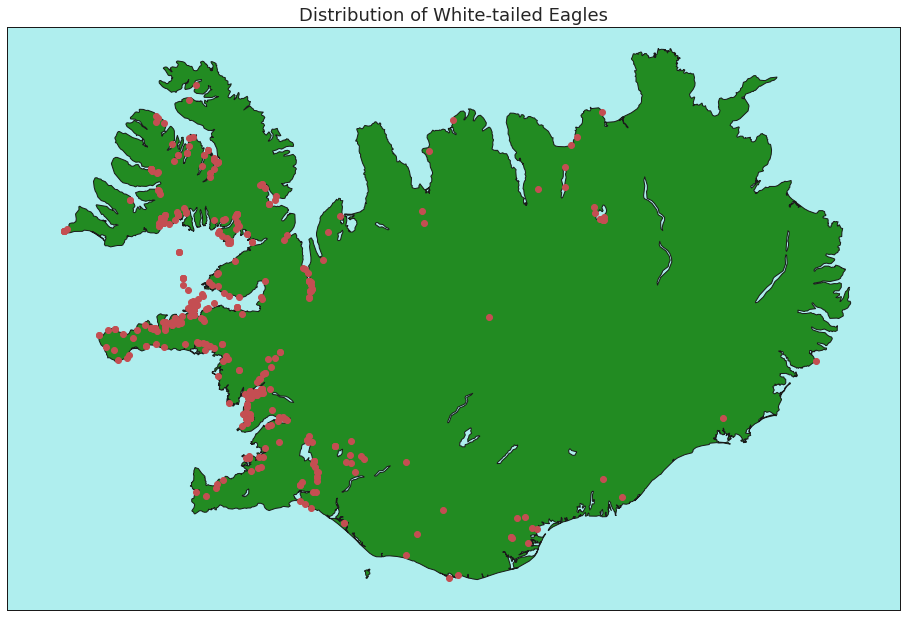

In [53]:
# First, we make a seperate dataframe that only contains the White-Tailed Eagles (Ísl: Haförn)
eagles = birds[birds["vernacularName"] == "White-tailed Eagle"] # 
# Second, we make a map by calling our helper function, make_map()
map = make_map()
# Third, we plot the location of the Eagles on our map by using plot_birds()
plot_birds(eagles, map)

plt.title("Distribution of White-tailed Eagles")
plt.show()

We can also plot the locations of multiple different species:

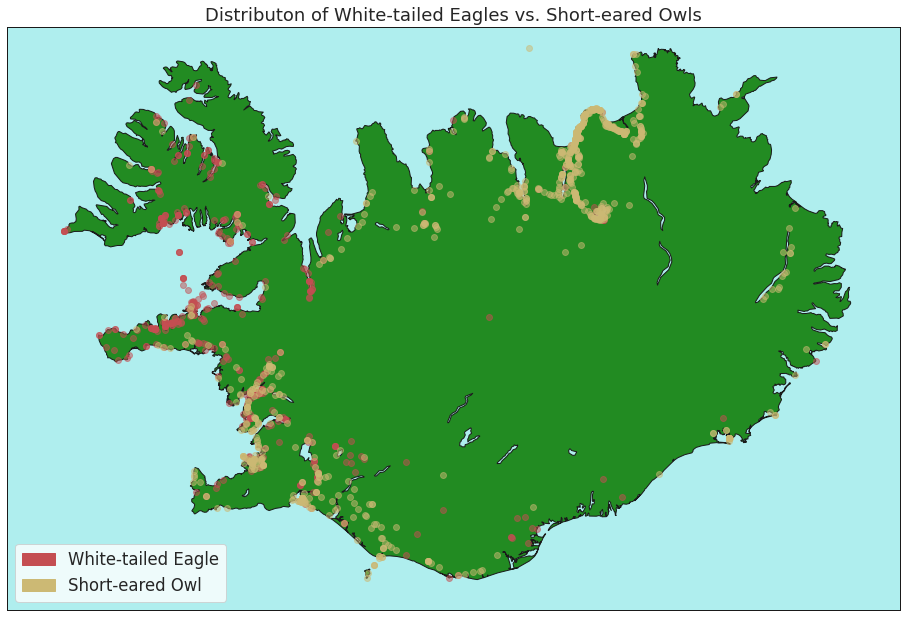

In [54]:
# Dataframe of Short-Eared Owls (Ísl: Brandugla)
shortEaredOwls = birds[birds["vernacularName"] == "Short-eared Owl"]


map = make_map()

# Here we set the alpha level to 0.5 to deal with overlapping markers 
plot_birds(eagles, map, "ro", .5) 
plot_birds(shortEaredOwls, map, "yo", .5)

eagle_patch = mpatches.Patch(color="r", label="White-tailed Eagle")
owl_patch = mpatches.Patch(color="y", label="Short-eared Owl")
plt.legend(handles=[eagle_patch, owl_patch], loc="lower left")
plt.title("Distributon of White-tailed Eagles vs. Short-eared Owls")
plt.show()